# Libraries Needed

The below codes import the necessary libraries needed to work on the project. The libraries being imported are necessary for Natural Language Processing task, data preprocessing, cleaning, data splitting, feature extraction and machine learning models implemented for this study 

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
nltk.download('punkt')
nltk.download('wordnet')
from nltk.tag import pos_tag #library used for POS tagging
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from collections import Counter
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.neighbors import KNeighborsClassifier
import seaborn as sns
import numpy as np
from gensim.models import Word2Vec
import multiprocessing
from sklearn.utils import resample
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output, State
import jupyter_dash
import base64

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Max\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Parsing CSV files:  

The below codes read data from the CSV file (dataset.csv) and displays the first five rows with headers

In [13]:
#Parse CSV file
tweets = pd.read_csv('dataset.csv')
columns = ['label', 'tweet']
tweets[columns].to_csv('tweets.csv', index=False)
tweets = pd.read_csv('tweets.csv')
pd.set_option('display.max_colwidth', None)
tweets.head(5)

,label,tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked
2,0,bihday your majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦
4,0,factsguide: society now #motivation


# Phase 1 - Data Exploration

In this phase, we learn the attributes of distribution of our dataset to get a guide on how to drive our analysis and preprocessing

The code below displays information about our tweet dataset providinga concise summary including the number of rows, the number of columns, the data type of each column, and the number of non-null values in each column.

In [14]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31962 entries, 0 to 31961
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   31962 non-null  int64 
 1   tweet   31962 non-null  object
dtypes: int64(1), object(1)
memory usage: 499.5+ KB


The code below checks for missing value in the data frame and prints a message indicating the number of missing value using string formatting

In [15]:
#Check for missing values
null_value = tweets.isnull().sum().sum()
print(f'There are {null_value} missing values.')

There are 0 missing values.


The code counts the number of rows in a DataFrame called 'tweets' based on the values in the 'label' column. It then prints the count of each unique value in the 'label' column. The result shows how many rows belong to each label category, providing an overview of the distribution of labels in the dataset.

In [16]:
# Count the rows based on the label_id column
row_counts = tweets['label'].value_counts()
# Print the count of each label_id
print(row_counts)

0    29720
1     2242
Name: label, dtype: int64


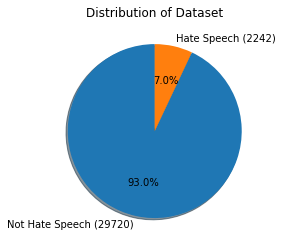

In [17]:
df = pd.DataFrame(tweets)

# Calculate the label counts
label_counts = df['label'].value_counts()

# Prepare the data for the pie chart
labels = ['Not Hate Speech ({})'.format(label_counts[0]), 'Hate Speech ({})'.format(label_counts[1])]
sizes = [label_counts[0], label_counts[1]]

# Create the pie chart
fig, ax = plt.subplots()
ax.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)

# Add a title and display
ax.set_title("Distribution of Dataset")
plt.show()

In [18]:
# # Extract the text column
# text_data = tweets['tweet'].astype(str)

# # Concatenate all the text data into a single string
# text = ' '.join(text_data)

# # Generate word cloud
# wordcloud = WordCloud().generate(text)

# # Create a plot and display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

print("skip")

skip


# Phase 2 - Data Cleaning and Normalisation

In this phase, we focus on preparing the tweet dataset for further analysis by performing data cleaning and normalization. The codes below outline the steps involved in this phase

In [19]:
#Regex expression, stopword and POS tagging
regex = r'@user|#\w+|[\.!&’?/♂️:,-]|\b\w{1,2}\b|\d+|[^\w\s]+'

# Stopwords
stop_words = set(stopwords.words('english'))

# POS tagging function
def get_wordnet_pos(treebank_tag):
    if treebank_tag.startswith('J'):
        return 'a'  # Adjective
    elif treebank_tag.startswith('V'):
        return 'v'  # Verb
    elif treebank_tag.startswith('N'):
        return 'n'  # Noun
    elif treebank_tag.startswith('R'):
        return 'r'  # Adverb
    else:
        return 'n'  # Default to noun

In [20]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatized_tweet(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE)  # Apply regex
    word = word.lower()  # Convert to lowercase
    tokens = word_tokenize(word)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Perform POS tagging
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        if token not in stop_words:
            pos_lemma = get_wordnet_pos(pos)
            lemmatized_token = lemmatizer.lemmatize(token, pos=pos_lemma)
            lemmatized_tokens.append(lemmatized_token)
    return " ".join(lemmatized_tokens)
tweets['lemmatized_tweet'] = tweets['tweet'].apply(lemmatized_tweet)
tweets.head(5)

,label,tweet,lemmatized_tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks credit use cause offer wheelchair van pdx
2,0,bihday your majesty,bihday majesty
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,love take time urð
4,0,factsguide: society now #motivation,factsguide society


In [21]:
# Initialize stemming (this was included for comparison, although, lemmatized text would be adopted)
stemmer = PorterStemmer()
def stemmed_text(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE) # Apply regex
    word = word.lower() # Convert to lower case
    tokens = word_tokenize(word) # Tokenize the text
    tokens = [stemmer.stem(token) for token in tokens if token not in stop_words] # stem the tokens
    return " ".join(tokens)
tweets['stemmed_tweet'] = tweets['tweet'].apply(stemmed_text)
tweets.head(5)

,label,tweet,lemmatized_tweet,stemmed_tweet
0,0,@user when a father is dysfunctional and is so selfish he drags his kids into his dysfunction. #run,father dysfunctional selfish drag kid dysfunction,father dysfunct selfish drag kid dysfunct
1,0,@user @user thanks for #lyft credit i can't use cause they don't offer wheelchair vans in pdx. #disapointed #getthanked,thanks credit use cause offer wheelchair van pdx,thank credit use caus offer wheelchair van pdx
2,0,bihday your majesty,bihday majesty,bihday majesti
3,0,#model i love u take with u all the time in urð±!!! ðððð ð¦ð¦ð¦,love take time urð,love take time urð
4,0,factsguide: society now #motivation,factsguide society,factsguid societi


In [24]:
# # Extract the text column
# text_data = tweets['stemmed_tweet'].astype(str)
# text = ' '.join(text_data) # Concatenate all the text data into a single string
# wordcloud = WordCloud().generate(text) # Generate word cloud
# print("WordCloud Stemmed Tweets")

# # Create a plot and display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()


print("skip")

skip


In [25]:
# # Extract the text column
# text_data = tweets['lemmatized_tweet'].astype(str)
# text = ' '.join(text_data) # Concatenate all the text data into a single string
# wordcloud = WordCloud().generate(text) # Generate word cloud
# print("WordCloud Lemmatized Tweets")

# # Create a plot and display the word cloud
# plt.imshow(wordcloud, interpolation='bilinear')
# plt.axis('off')
# plt.show()

print("skip")

skip


In [26]:
# Split the dataset into training and test sets
train_set, test_set = train_test_split(tweets, test_size=0.2, random_state=42)
# Save the training set to a CSV file
train_set.to_csv('train_set.csv', index=False)
# Save the test set to a CSV file
test_set.to_csv('test_set.csv', index=False)

# Machine Learning

In this phase, we will train several machine learning models using the cleaned and normalized tweet dataset. The code below outlines the steps involved in this phase

### Approach 1. Upsample then Vectorisation (TFIDF & WORD2VEC)

In [27]:
#read in train dataset
train_tweets = pd.read_csv('train_set.csv')
columns = ['label', 'lemmatized_tweet']
train_tweets[columns].to_csv('train_tweets.csv', index=False)
train_tweets = pd.read_csv('train_tweets.csv')
pd.set_option('display.max_colwidth', None)
train_tweets.head(5)

,label,lemmatized_tweet
0,1,pay attention past year year
1,0,raft building salford quays gmw fun outdoors badge
2,0,friday
3,0,true
4,0,gracious muse jewelry


In [28]:
# Count the rows based on the label_id column
train_tweets_row_counts = train_tweets['label'].value_counts()
# Print the count of each label_id
print(train_tweets_row_counts)

0    23783
1     1786
Name: label, dtype: int64


In [29]:
#Check for missing values
null_value2 = train_tweets_row_counts.isnull().sum().sum()
print(f'There are {null_value2} missing values.')

There are 0 missing values.


In [30]:
# Separate the majority and minority classes
majority_class = train_tweets[train_tweets['label'] == 0]
minority_class = train_tweets[train_tweets['label'] == 1]
# Upsample the minority class
upsampled_minority = resample(minority_class,
                              replace=True,  # Sample with replacement
                              n_samples=len(majority_class),  # Match the number of instances in the majority class
                              random_state=42)
# Combine the upsampled minority class with the majority class
upsampled_train_tweets = pd.concat([majority_class, upsampled_minority])
# Shuffle the upsampled dataset
upsampled_train_tweets = upsampled_train_tweets.sample(frac=1, random_state=42)
# Print the class distribution after upsampling
print(upsampled_train_tweets['label'].value_counts())

1    23783
0    23783
Name: label, dtype: int64


In [31]:
test_tweets = pd.read_csv('test_set.csv')
test_data = test_tweets[['label', 'lemmatized_tweet']]

In [32]:
#Pipeline creation using TF-IDF vectoriser and five classifiers

def TFIDF_pipeline(classifier):
    # Define the pipeline steps
    steps = [
        ('vectorizer', TfidfVectorizer()),
        ('classifier', classifier)
    ]
    # Create the NLP pipeline
    TFIDF_nlp_pipeline = Pipeline(steps)
    return TFIDF_nlp_pipeline

# Instantiate the classifiers
NB_TFIDF = MultinomialNB()
LR_TFIDF = LogisticRegression()
SVM_TFIDF = SVC()
RF_TFIDF = RandomForestClassifier()
DT_TFIDF = DecisionTreeClassifier()

# Create the NLP pipelines for NB, LR, SVM, RF, DT using TFIDF text representation
TFIDF_NB_pipeline = TFIDF_pipeline(NB_TFIDF)
TFIDF_LR_pipeline = TFIDF_pipeline(LR_TFIDF)
TFIDF_SVM_pipeline = TFIDF_pipeline(SVM_TFIDF)
TFIDF_RF_pipeline = TFIDF_pipeline(RF_TFIDF)
TFIDF_DT_pipeline = TFIDF_pipeline(DT_TFIDF)

In [33]:
#Creation of Word2Vec model
sentences = [tweet.split() for tweet in tweets['lemmatized_tweet']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=multiprocessing.cpu_count())
#Custom vectorizer for Word2Vec
class Word2VecVectorizer:
    def __init__(self, word2vec_model):
        self.word2vec_model = word2vec_model
    def transform(self, X):
        return np.array([self.get_word2vec_embedding(text) for text in X])
    def get_word2vec_embedding(self, text):
        words = text.split()
        embeddings = []
        for word in words:
            if word in self.word2vec_model.wv:
                embeddings.append(self.word2vec_model.wv[word])
        if embeddings:
            return np.mean(embeddings, axis=0)
        else:
            return np.zeros(self.word2vec_model.vector_size)
    def fit(self, X, y=None):
        return self
    
# NLP Pipeline with Word2Vec
pipeline_lr = Pipeline([
    ('word2vec', Word2VecVectorizer(word2vec_model)),  # Custom Word2Vec vectorizer
    ('classifier', LogisticRegression(max_iter=1000))
])
pipeline_dt = Pipeline([
    ('word2vec', Word2VecVectorizer(word2vec_model)),  # Custom Word2Vec vectorizer
    ('classifier', DecisionTreeClassifier())
])
pipeline_rf = Pipeline([
    ('word2vec', Word2VecVectorizer(word2vec_model)),  # Custom Word2Vec vectorizer
    ('classifier', RandomForestClassifier())
])
pipeline_svm = Pipeline([
    ('word2vec', Word2VecVectorizer(word2vec_model)),  # Custom Word2Vec vectorizer
    ('classifier', SVC())
])

In [34]:
#training and prediction results using TF-IDF vectoriser and five classifiers
upsampled_train_tweets['lemmatized_tweet'].fillna('', inplace=True)
test_data['lemmatized_tweet'].fillna('', inplace=True)

#Naive Bayes
TFIDF_NB_pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])#Fit the NB pipeline to training data
LEM_pred_NB = TFIDF_NB_pipeline.predict(test_data['lemmatized_tweet'])#Predict on the test data using NB
LEM_accuracy_NB = accuracy_score(test_data['label'], LEM_pred_NB)
LEM_train_pred_NB = TFIDF_NB_pipeline.predict(upsampled_train_tweets['lemmatized_tweet'])
LEM_train_accuracy_NB = accuracy_score(upsampled_train_tweets['label'], LEM_train_pred_NB)

#Logistic Regression
TFIDF_LR_pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])#Fit the LR pipeline to training data
LEM_pred_LR = TFIDF_LR_pipeline.predict(test_data['lemmatized_tweet'])#Predict on the test data using LR
LEM_accuracy_LR = accuracy_score(test_data['label'], LEM_pred_LR)
LEM_train_pred_LR = TFIDF_LR_pipeline.predict(upsampled_train_tweets['lemmatized_tweet'])
LEM_train_accuracy_LR = accuracy_score(upsampled_train_tweets['label'], LEM_train_pred_LR)

#Support Vector Machine
TFIDF_SVM_pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])#Fit the SVM pipeline to training data
LEM_pred_SVM = TFIDF_SVM_pipeline.predict(test_data['lemmatized_tweet'])#Predict on the test data using SVM
LEM_accuracy_SVM = accuracy_score(test_data['label'], LEM_pred_SVM)
LEM_train_pred_SVM = TFIDF_SVM_pipeline.predict(upsampled_train_tweets['lemmatized_tweet'])
LEM_train_accuracy_SVM = accuracy_score(upsampled_train_tweets['label'], LEM_train_pred_SVM)

#Random Forest
TFIDF_RF_pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])#Fit the RF pipeline to training data
LEM_pred_RF = TFIDF_RF_pipeline.predict(test_data['lemmatized_tweet'])#Predict on the test data using RF
LEM_accuracy_RF = accuracy_score(test_data['label'], LEM_pred_RF)
LEM_train_pred_RF = TFIDF_RF_pipeline.predict(upsampled_train_tweets['lemmatized_tweet'])
LEM_train_accuracy_RF = accuracy_score(upsampled_train_tweets['label'], LEM_train_pred_RF)

#Decision Tree
TFIDF_DT_pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])#Fit the DT pipeline to training data
LEM_pred_DT = TFIDF_DT_pipeline.predict(test_data['lemmatized_tweet'])#Predict on the test data using DT
LEM_accuracy_DT = accuracy_score(test_data['label'], LEM_pred_DT)
LEM_train_pred_DT = TFIDF_DT_pipeline.predict(upsampled_train_tweets['lemmatized_tweet'])
LEM_train_accuracy_DT = accuracy_score(upsampled_train_tweets['label'], LEM_train_pred_DT)

#Reports
report_train_NB = classification_report(upsampled_train_tweets['label'], LEM_train_pred_NB, zero_division=0)
report_NB = classification_report(test_data['label'], LEM_pred_NB, zero_division=0)
# print("NB Classification Report (Train Dataset):")
# print(f"NB Accuracy (Train Dataset): {LEM_train_accuracy_NB:.4f}")
# print(report_train_NB)
print()
print("NB Classification Report (Test Dataset):")
print(f"NB Accuracy (Test Dataset): {LEM_accuracy_NB:.4f}")
print(report_NB)

report_train_LR = classification_report(upsampled_train_tweets['label'], LEM_train_pred_LR, zero_division=0)
report_LR = classification_report(test_data['label'], LEM_pred_LR, zero_division=0)
# print("LR Classification Report (Train Dataset):")
# print(f"LR Accuracy (Train Dataset): {LEM_train_accuracy_LR:.4f}")
# print(report_train_LR)
print()
print("LR Classification Report (Test Dataset):")
print(f"LR Accuracy (Test Dataset): {LEM_accuracy_LR:.4f}")
print(report_LR)

report_train_SVM = classification_report(upsampled_train_tweets['label'], LEM_train_pred_SVM, zero_division=0)
report_SVM = classification_report(test_data['label'], LEM_pred_SVM, zero_division=0)
# print("SVM Classification Report (Train Dataset):")
# print(f"SVM Accuracy (Train Dataset): {LEM_train_accuracy_SVM:.4f}")
# print(report_train_SVM)
print()
print("SVM Classification Report (Test Dataset):")
print(f"SVM Accuracy (Test Dataset): {LEM_accuracy_SVM:.4f}")
print(report_SVM)

report_train_DT = classification_report(upsampled_train_tweets['label'], LEM_train_pred_DT, zero_division=0)
report_DT = classification_report(test_data['label'], LEM_pred_DT, zero_division=0)
# print("DT Classification Report (Train Dataset):")
# print(f"DT Accuracy (Train Dataset): {LEM_train_accuracy_DT:.4f}")
# print(report_train_DT)
print()
print("DT Classification Report (Test Dataset):")
print(f"DT Accuracy (Test Dataset): {LEM_accuracy_DT:.4f}")
print(report_DT)

C:\Users\Max\AppData\Local\Temp\ipykernel_18912\853931414.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['lemmatized_tweet'].fillna('', inplace=True)



NB Classification Report (Test Dataset):
NB Accuracy (Test Dataset): 0.8681
              precision    recall  f1-score   support

           0       0.98      0.88      0.93      5937
           1       0.32      0.73      0.44       456

    accuracy                           0.87      6393
   macro avg       0.65      0.81      0.68      6393
weighted avg       0.93      0.87      0.89      6393


LR Classification Report (Test Dataset):
LR Accuracy (Test Dataset): 0.9022
              precision    recall  f1-score   support

           0       0.97      0.92      0.95      5937
           1       0.39      0.68      0.50       456

    accuracy                           0.90      6393
   macro avg       0.68      0.80      0.72      6393
weighted avg       0.93      0.90      0.91      6393


SVM Classification Report (Test Dataset):
SVM Accuracy (Test Dataset): 0.9496
              precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
    

In [35]:
#Training, Prediction result using Word2Vec
pipelines = [pipeline_lr, pipeline_dt, pipeline_rf, pipeline_svm]
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'SVM']

for pipeline, model_name in zip(pipelines, model_names):
    # Train the model
    pipeline.fit(upsampled_train_tweets['lemmatized_tweet'], upsampled_train_tweets['label'])  

    # Predict on the test set
    y_test_pred = pipeline.predict(test_data['lemmatized_tweet'])
        
    # Evaluate the model on test set
    print("Model:", model_name)
    print("Test Accuracy:", accuracy_score(test_data['label'], y_test_pred))
    print("Test Classification Report:\n", classification_report(test_data['label'], y_test_pred, zero_division=0))
    print("-----------------------------\n")

Model: Logistic Regression
Test Accuracy: 0.6175504458000939
Test Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.60      0.75      5937
           1       0.14      0.81      0.23       456

    accuracy                           0.62      6393
   macro avg       0.56      0.71      0.49      6393
weighted avg       0.92      0.62      0.71      6393

-----------------------------

Model: Decision Tree
Test Accuracy: 0.9103707179727827
Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      5937
           1       0.38      0.39      0.38       456

    accuracy                           0.91      6393
   macro avg       0.66      0.67      0.67      6393
weighted avg       0.91      0.91      0.91      6393

-----------------------------

Model: Random Forest
Test Accuracy: 0.9450961989676209
Test Classification Report:
               precision   

### Approach 2. Vectorisation then Upsample (TFIDF)

In [36]:
### upsampled, splitted, vectorised and algorithm merged.. using TFIDF

# Read in the dataset
df = pd.read_csv('dataset.csv')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()
def lemmatized_tweet(word):
    word = re.sub(regex, '', word, flags=re.MULTILINE)  # Apply regex
    word = word.lower()  # Convert to lowercase
    tokens = word_tokenize(word)  # Tokenize the text
    tagged_tokens = pos_tag(tokens)  # Perform POS tagging
    lemmatized_tokens = []
    for token, pos in tagged_tokens:
        if token not in stop_words:
            pos_lemma = get_wordnet_pos(pos)
            lemmatized_token = lemmatizer.lemmatize(token, pos=pos_lemma)
            lemmatized_tokens.append(lemmatized_token)
    return " ".join(lemmatized_tokens)
df['lemmatized_tweet'] = df['tweet'].apply(lemmatized_tweet)
# df.head(5)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df['tweet'], df['label'], test_size=0.2, random_state=42)

# Vectorize using TF-IDF
vectorizer = TfidfVectorizer()
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Upsample the train dataset (assuming class imbalance)
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['label'] == 0]
df_minority = df_train[df_train['label'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X_train_upsampled = df_upsampled['tweet']
y_train_upsampled = df_upsampled['label']

# Vectorize the upsampled training data
X_train_upsampled_vectorized = vectorizer.transform(X_train_upsampled)

# Implement Naive Bayes classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
nb_predictions = nb_classifier.predict(X_test_vectorized)

# Implement Random Forest classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
lr_predictions = lr_classifier.predict(X_test_vectorized)

# Implement Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
dt_predictions = dt_classifier.predict(X_test_vectorized)

# Implement SVM classifier
svm_classifier2 = SVC()
svm_classifier2.fit(X_train_upsampled_vectorized, y_train_upsampled)
svm_predictions = svm_classifier2.predict(X_test_vectorized)

# Print classification report for Naive Bayes
print("Naive Bayes Classifier:")
print(classification_report(y_test, nb_predictions))

# Print classification report for Random Forest
print("Logistic Regression Classifier:")
print(classification_report(y_test, lr_predictions))

# Print classification report for Decision Tree
print("Decision Tree Classifier:")
print(classification_report(y_test, dt_predictions))

# Print classification report for SVM
print("SVM Classifier:")
print(classification_report(y_test, svm_predictions))

Naive Bayes Classifier:
              precision    recall  f1-score   support

           0       0.99      0.92      0.95      5937
           1       0.44      0.87      0.59       456

    accuracy                           0.91      6393
   macro avg       0.72      0.89      0.77      6393
weighted avg       0.95      0.91      0.93      6393

Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.98      0.95      0.97      5937
           1       0.58      0.81      0.67       456

    accuracy                           0.94      6393
   macro avg       0.78      0.88      0.82      6393
weighted avg       0.96      0.94      0.95      6393

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      5937
           1       0.41      0.54      0.46       456

    accuracy                           0.91      6393
   macro avg       0.69      0.74      0.71   

###  Vectorisation then Upsample (word2vec)

In [37]:
# Read in the dataset
df = pd.read_csv('dataset.csv')

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Preprocessing function
def preprocess_tweet(tweet):
    tweet = re.sub(regex, '', tweet, flags=re.MULTILINE)  # Apply regex
    tweet = tweet.lower()  # Convert to lowercase
    tokens = word_tokenize(tweet)  # Tokenize the text
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    return filtered_tokens
# Apply preprocessing to tweets
df['processed_tweet'] = df['tweet'].apply(preprocess_tweet)

# Split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df['processed_tweet'], df['label'], test_size=0.2, random_state=42)

# Function to vectorize a tweet using Word2Vec
def vectorize_tweet(tweet):
    vectors = []
    for token in tweet:
        if token in word2vec_model.wv:
            vectors.append(word2vec_model.wv[token])
    return np.mean(vectors, axis=0) if vectors else np.zeros(word2vec_model.vector_size)

# Vectorize the train and test datasets
X_train_vectorized = [vectorize_tweet(tweet) for tweet in X_train]
X_test_vectorized = [vectorize_tweet(tweet) for tweet in X_test]

# Convert vectorized data to numpy arrays
X_train_vectorized = np.array(X_train_vectorized)
X_test_vectorized = np.array(X_test_vectorized)

# Upsample the train dataset (assuming class imbalance)
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['label'] == 0]
df_minority = df_train[df_train['label'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X_train_upsampled = df_upsampled['processed_tweet']
y_train_upsampled = df_upsampled['label']

# Vectorize the upsampled training data
X_train_upsampled_vectorized = [vectorize_tweet(tweet) for tweet in X_train_upsampled]
X_train_upsampled_vectorized = np.array(X_train_upsampled_vectorized)

# Implement SVM classifier
svm_classifier = SVC()
svm_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
svm_predictions = svm_classifier.predict(X_test_vectorized)

# Implement Logistic Regression classifier
lr_classifier = LogisticRegression()
lr_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
lr_predictions = lr_classifier.predict(X_test_vectorized)

# Implement Decision Tree classifier
dt_classifier = DecisionTreeClassifier()
dt_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
dt_predictions = dt_classifier.predict(X_test_vectorized)

# Implement Random Forest classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_upsampled_vectorized, y_train_upsampled)
rf_predictions = rf_classifier.predict(X_test_vectorized)

#print classificatiion reports
print("Logistic Regression Classifier:")
print(classification_report(y_test, lr_predictions))
print("Decision Tree Classifier:")
print(classification_report(y_test, dt_predictions))
print("Random Forest Classifier:")
print(classification_report(y_test, rf_predictions))
print("SVM Classifier:")
print(classification_report(y_test, svm_predictions))

C:\Users\Max\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic Regression Classifier:
              precision    recall  f1-score   support

           0       0.97      0.60      0.74      5937
           1       0.13      0.79      0.22       456

    accuracy                           0.61      6393
   macro avg       0.55      0.69      0.48      6393
weighted avg       0.91      0.61      0.70      6393

Decision Tree Classifier:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      5937
           1       0.37      0.39      0.38       456

    accuracy                           0.91      6393
   macro avg       0.66      0.67      0.66      6393
weighted avg       0.91      0.91      0.91      6393

Random Forest Classifier:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5937
           1       0.80      0.32      0.45       456

    accuracy                           0.95      6393
   macro avg       0.88      0.65      0.71 

## Deep Learning

In this section, we will train a deep learning model using the cleaned and normalized tweet dataset. The code below outlines the steps involved using tensor flow

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

# Tokenize the text data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_tokens = tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)

# Pad sequences to have the same length
max_sequence_length = 100  # Define the maximum length for padding
X_train_padded = pad_sequences(X_train_tokens, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_tokens, maxlen=max_sequence_length)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train_padded, y_train, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Predict on the training and testing sets
y_train_pred_probs = model.predict(X_train_padded)
y_test_pred_probs = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
y_train_pred = [1 if pred > 0.5 else 0 for pred in y_train_pred_probs]
y_test_pred = [1 if pred > 0.5 else 0 for pred in y_test_pred_probs]

test_precision = precision_score(y_test, y_test_pred)
test_recall = recall_score(y_test, y_test_pred)
test_f1 = f1_score(y_test, y_test_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)
print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)

Epoch 1/10
800/800 [==============================] - 267s 323ms/step - loss: 0.1994 - accuracy: 0.9399 - val_loss: 0.1639 - val_accuracy: 0.9478
Epoch 2/10
800/800 [==============================] - 258s 323ms/step - loss: 0.1023 - accuracy: 0.9666 - val_loss: 0.1662 - val_accuracy: 0.9485
Epoch 3/10
800/800 [==============================] - 250s 313ms/step - loss: 0.0616 - accuracy: 0.9805 - val_loss: 0.2024 - val_accuracy: 0.9474
Epoch 4/10
200/200 [==============================] - 8s 38ms/step
Test Accuracy: 0.9477553574221805
Test Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.99      0.97      5937
           1       0.74      0.41      0.53       456

    accuracy                           0.95      6393
   macro avg       0.85      0.70      0.75      6393
weighted avg       0.94      0.95      0.94      6393



In the below code, we upsample our dataset before using training our deep learning model 

In [39]:
# Upsample the train dataset (assuming class imbalance)
df_train = pd.concat([X_train, y_train], axis=1)
df_majority = df_train[df_train['label'] == 0]
df_minority = df_train[df_train['label'] == 1]
df_minority_upsampled = resample(df_minority, replace=True, n_samples=len(df_majority), random_state=42)
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
X_train_upsampled = df_upsampled['processed_tweet']
y_train_upsampled = df_upsampled['label']

# Tokenize the upsampled train data
tokenizer.fit_on_texts(X_train_upsampled)
X_train_upsampled_tokens = tokenizer.texts_to_sequences(X_train_upsampled)
X_train_upsampled_padded = pad_sequences(X_train_upsampled_tokens, maxlen=max_sequence_length)

# Build the model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=100, input_length=max_sequence_length),
    tf.keras.layers.LSTM(units=128, dropout=0.2, recurrent_dropout=0.2),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dropout(rate=0.3),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping
model.fit(X_train_upsampled_padded, y_train_upsampled, batch_size=32, epochs=10, validation_data=(X_test_padded, y_test), callbacks=[early_stopping])

# Predict on the training and testing sets
# y_train_pred_probs = model.predict(X_train_padded)
y_test_pred_probs = model.predict(X_test_padded)

# Convert predicted probabilities to class labels
# y_train_pred = [1 if pred > 0.5 else 0 for pred in y_train_pred_probs]
y_test_pred = [1 if pred > 0.5 else 0 for pred in y_test_pred_probs]

# Calculate precision, recall, and F1-score
# train_accuracy = accuracy_score(y_train, y_train_pred)
# train_report = classification_report(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

# print("Train Accuracy:", train_accuracy)
# print("Train Classification Report:\n", train_report)

print("Test Accuracy:", test_accuracy)
print("Test Classification Report:\n", test_report)


Epoch 1/10
1487/1487 [==============================] - 380s 252ms/step - loss: 0.1957 - accuracy: 0.9206 - val_loss: 1.0539 - val_accuracy: 0.7419
Epoch 2/10
1487/1487 [==============================] - 464s 312ms/step - loss: 0.0517 - accuracy: 0.9821 - val_loss: 1.4350 - val_accuracy: 0.7737
Epoch 3/10
1487/1487 [==============================] - 509s 342ms/step - loss: 0.0328 - accuracy: 0.9878 - val_loss: 1.5269 - val_accuracy: 0.7974
Epoch 4/10
200/200 [==============================] - 14s 64ms/step
Test Accuracy: 0.7419052088221493
Test Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.79      0.85      5937
           1       0.06      0.17      0.09       456

    accuracy                           0.74      6393
   macro avg       0.49      0.48      0.47      6393
weighted avg       0.86      0.74      0.80      6393



# Prototype

In [40]:
# Create the app
app = jupyter_dash.JupyterDash(__name__)
image_path = 'logo.png'
with open(image_path, 'rb') as f:
    encoded_image = base64.b64encode(f.read()).decode()

# Header component
header = html.Header(
    children=[
        html.H1("Hate Speech Detection", style={'float': 'right', 'paddingLeft': '180px', 'paddingBottom': '20px', 'marginBottom': '0', 'width': '90%'}),
        html.Div(
            children=[
                html.Img(src='data:logo/png;base64,{}'.format(encoded_image), style={'width': '100%', 'height': '100%'})
            ],
            style={'width': '6%', 'float': 'right', 'height': '50px', 'paddingRight': '10px'}
        )
    ],
    style={"color": "white", "paddingTop": "20px", "backgroundColor": "#000000", "textAlign": "center", "display": "flex", "justifyContent": "center", "width": "100%"}
)
# Footer component
footer = html.Footer(
    html.P("© 2023 A Hate Speech Detection Prototype."),
    style={
                "bottom": "0",
                "width": "100%",
                "height": "60px",
                "backgroundColor": "#000000",
                "color": "#fff",
                "textAlign": "center",
                "paddingTop": "20px",
            }
)
app.layout = html.Div([
    header,
    html.Div([
        dcc.Input(id='text', type="text", placeholder="Enter your text", value=" ", style={'width': '600px'}),
        html.Button('Detect', id='detect-button', style={'marginTop': '10px'}),
        html.Div(id='prediction-output')
    ],
    style={"backgroundColor": "#f2f2f2", "textAlign": "center", 'height': '60vh', 'display': 'flex', 'width': '100%', 'flexDirection': 'column', 'alignItems': 'center', 'justifyContent': 'center'}),
    html.Div([
        html.P("""Disclaimer:
            The hate speech detection prototype was engineered for demonstrative purposes only and is not intended for real-world application without further refinement. It is worth noting that this prototype may not possess optimal generalisation capabilities due to limitations in its dataset and the sampling technique employed during its development.
            
            The model's performance in detecting hate speech may be influenced by the dataset it was trained on, which might not encompass the full spectrum of hate speech variations present in the real world.""")
    ]),
    footer
])


vectorizer = TfidfVectorizer()
# vectorizer = TfidfVectorizer(ngram_range=(1, 3)) 

# Read the CSV file into a pandas DataFrame
tweets = pd.read_csv('train_set.csv')

# Preprocess dataset to handle NaN values
tweets['lemmatized_tweet'].fillna('', inplace=True)

# Extract the tweet text and labels from the DataFrame
training_data = tweets['lemmatized_tweet'].tolist()
training_labels = tweets['label'].tolist()

# Fit the vectorizer on training data
vectorizer.fit(training_data)

# Train the Support Vector Machine model
svm_model = SVC()
text_vectorized_train = vectorizer.transform(training_data)
svm_model.fit(text_vectorized_train, training_labels)

# joblib.dump(clf, 'svm_model.joblib')

# # Load the model from joblib
# clf_model = joblib.load('svm_model.joblib')


@app.callback(
    Output('prediction-output', 'children'),
    [Input('detect-button', 'n_clicks')],
    [State('text', 'value')]
)
def detect_hate_speech(n_clicks, text):
    if text:
        processed = lemmatized_tweet(text)
        text_vectorized = vectorizer.transform([processed])
        text_vectorized_dense = text_vectorized.toarray()
        prediction = svm_model.predict(text_vectorized)[0]
        
        if prediction == 1:
            result = html.H3("Hate Speech Detected!", style={'color': 'red'})
        else:
            result = html.H3("Non-Hate Speech", style={'color': 'green'})
    else:
        result = html.H3("Please enter some text")
    
    return result  

if __name__ == "__main__":
    app.run_server(mode='inline', debug=False, port=1000)

Dash is running on http://127.0.0.1:1000/



 * Running on http://127.0.0.1:1000/ (Press CTRL+C to quit)
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_alive_4df90692-28d6-4130-ba02-d869df760182 HTTP/1.1" 200 -


127.0.0.1 - - [11/Oct/2024 15:02:07] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/deps/polyfill@7.v2_9_2m1680261794.12.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/deps/react@16.v2_9_2m1680261794.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/deps/react-dom@16.v2_9_2m1680261794.14.0.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/deps/prop-types@15.v2_9_2m1680261794.8.1.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/dash-renderer/build/dash_renderer.v2_9_2m1680261794.min.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/dcc/dash_core_components.v2_9_1m1680261794.js HTTP/1.1" 200 -
127.0.0.1 - - [11/Oct/2024 15:02:07] "GET /_dash-component-suites/dash/html/dash_html_components.v2_0_10m1680261795.min.js HTTP

#                                                          The End